In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import KNNImputer
from statsmodels.tsa.stattools import adfuller

import shap
shap.initjs()
import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv("../working_data/dataset.csv", index_col=0)

In [3]:
df = df[df["Category"] != "Industrial Crops"]

## Creating working data frame

In [4]:
#df['Year'] = pd.to_datetime(df['Year'], format='%Y')
#df.set_index("Year", inplace=True)
# getting list of names
categories = df["Category"].unique()

## Creating the metrics data frame

In [5]:
shap_df = pd.DataFrame()

## Random Forest Regression

### Setting up dataframe

#### - Solving for stationarity

In [6]:
imputer = KNNImputer(n_neighbors=4)
adf_df = pd.DataFrame(columns=df.columns)

for cate in categories: 
    # Selects category
    crop_df = df[df["Category"] == cate]
    num_cols = crop_df.select_dtypes(include=[np.number])
    # Selects column for ADF Test
    for col in num_cols:
        if crop_df[col].count() < 5:
            continue
        adf_result = adfuller(crop_df[col])
        while adf_result[1] > 0.05:
            crop_df[col] = crop_df[col].diff()
            crop_df[num_cols.columns] = imputer.fit_transform(crop_df[num_cols.columns])
            adf_result = adfuller(crop_df[col])

    adf_df = pd.concat([adf_df, crop_df])

#### - Transforming time series data to supervised learning (adding lags to variables)

In [7]:
main_df = pd.DataFrame(columns=adf_df.columns)
imputer = KNNImputer(n_neighbors=4)

# Sliding Window
for cate in categories: 
    # Selects category
    crop_df = adf_df[adf_df["Category"] == cate]
    num_cols = crop_df.select_dtypes(include=[np.number])
    for col in num_cols.columns:   
        for i in range(1, 3):
            crop_df[f'{col}-{i}'] = crop_df[col].shift(i)

    main_df = pd.concat([main_df, crop_df])
    num_cols = main_df.select_dtypes(include=[np.number])
    main_df[num_cols.columns] = imputer.fit_transform(main_df[num_cols.columns])

## Running the model

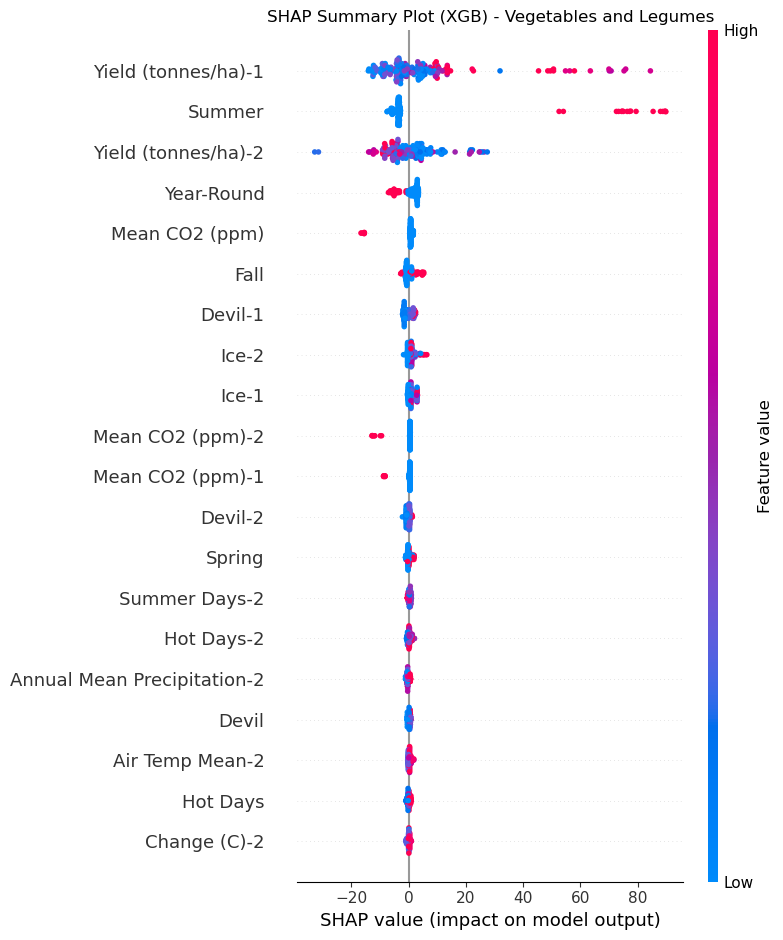

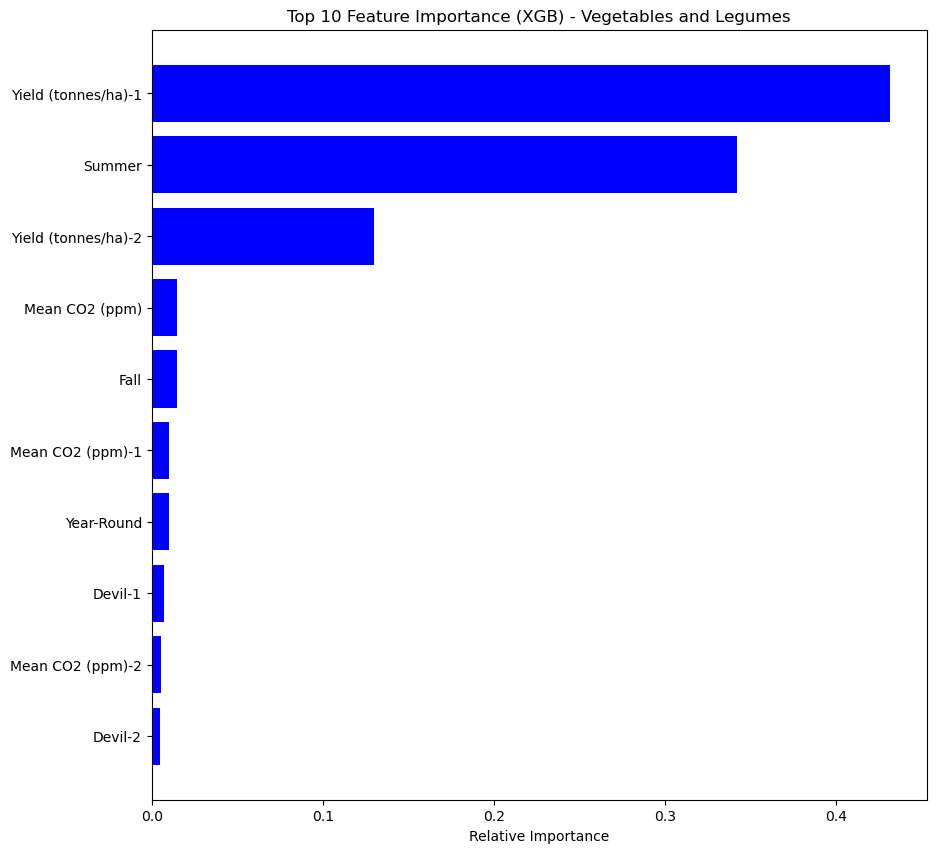

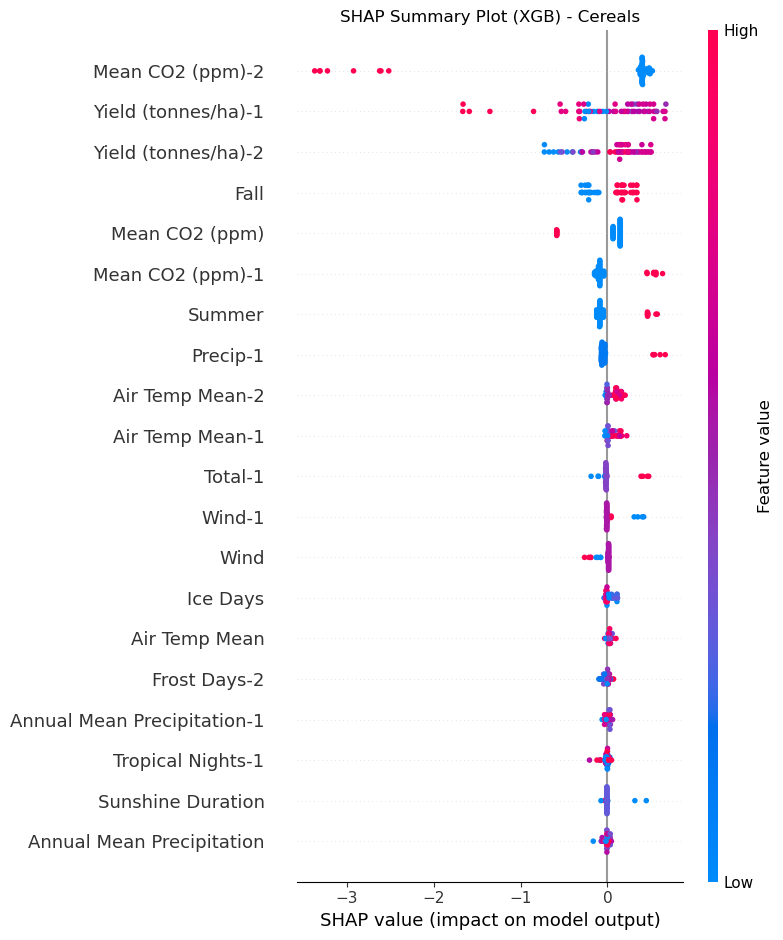

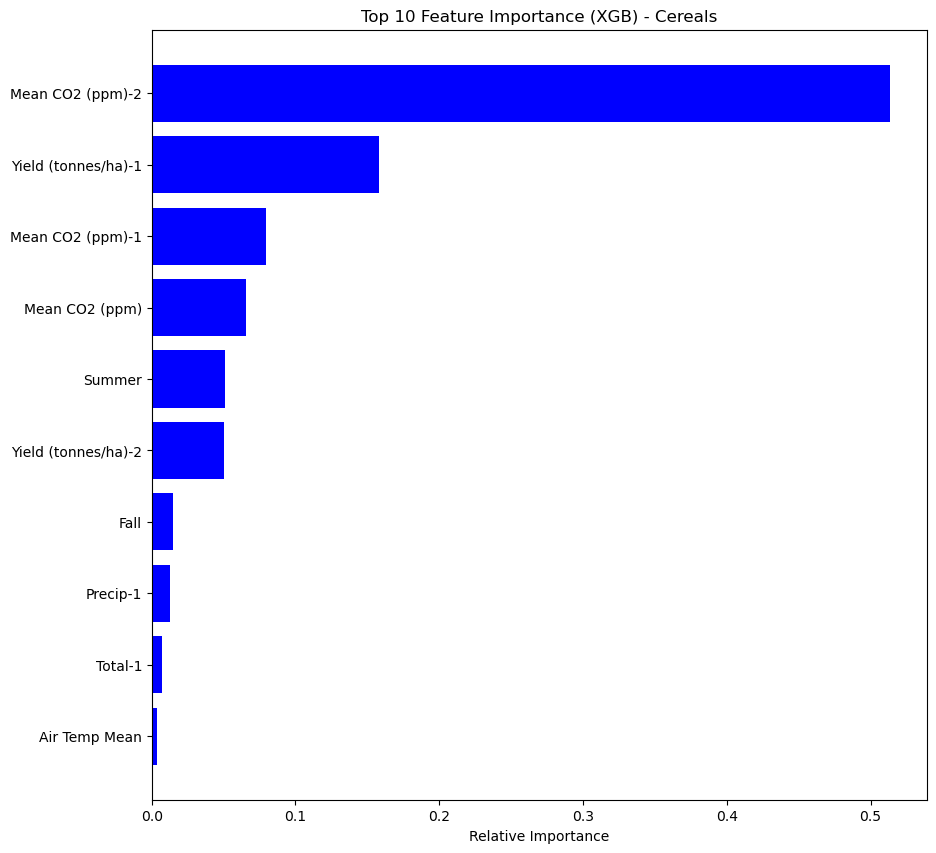

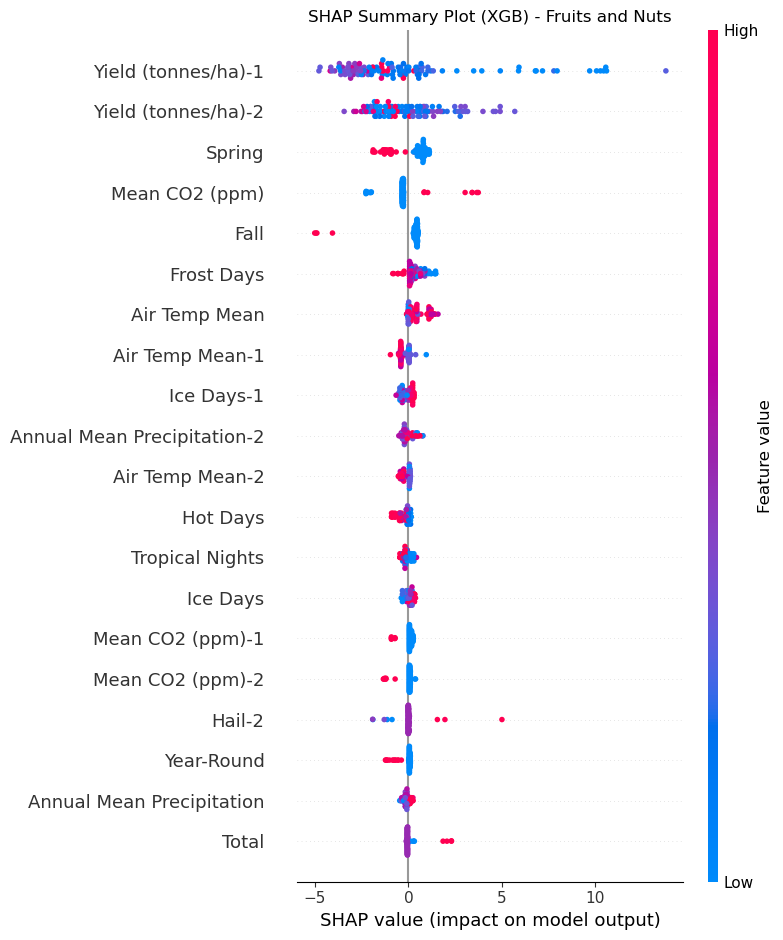

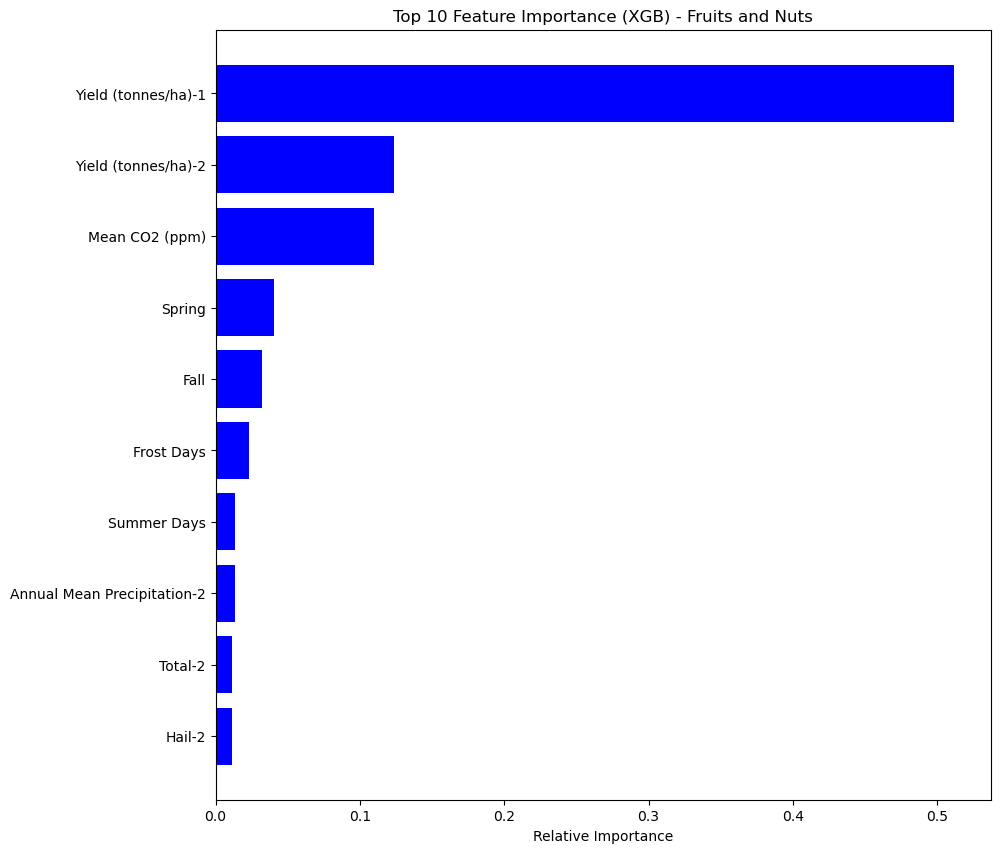

In [8]:
scaler = MinMaxScaler()
for cat in categories:
   crop_df = main_df[main_df['Category'] == cat]
   encoded_df = pd.get_dummies(crop_df[["Season"]], prefix='', prefix_sep='')
   encoded_df = encoded_df.drop(encoded_df.columns[-2], axis=1)

   y = crop_df[['Yield (tonnes/ha)']]
   x = crop_df.drop(['Yield (tonnes/ha)', "Item", "Category", "Season"], axis=1)
   x = pd.concat([x, encoded_df], axis=1)

   mean = x.mean()
   std = x.std()
   lower_bound = mean - 2 * std
   upper_bound = mean + 2 * std
   x = x.clip(lower_bound, upper_bound, axis=1)

   x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
   
   x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False, random_state=42)
   regressor = GradientBoostingRegressor(n_estimators = 400, random_state = 42, learning_rate=0.2)
   regressor.fit(x_train, y_train)
   
   #prediction of new value
   y_pred = regressor.predict(x_test)
   
   explainer = shap.TreeExplainer(regressor)
   shap_values = explainer.shap_values(x_test, check_additivity=False)

   # Adding SHAP Data into DataFrame
   shap_df_crop = pd.DataFrame(shap_values, columns=x_test.columns)
   shap_df_crop[cat] = cat
   shap_mean_crop = shap_df_crop.mean()
   shap_df[cat] = shap_mean_crop 
   
   # SHAP Summary
   plt.title("SHAP Summary Plot (XGB) - " + cat)
   shap.summary_plot(shap_values, x_test, feature_names=x_test.columns)
   plt.show()

   # Plotting Feature Importance
   importances = regressor.feature_importances_
   indices = np.argsort(importances)[-10:]
   features = x_test.columns
   plot_df = pd.DataFrame()
   plt.figure(figsize=(10, 10))
   plt.title('Top 10 Feature Importance (XGB) - ' + cat)
   plt.barh(range(len(indices)), importances[indices], color='b', align='center')
   plt.yticks(range(len(indices)), [features[i] for i in indices])
   plt.xlabel('Relative Importance')
   plt.show()

## Results

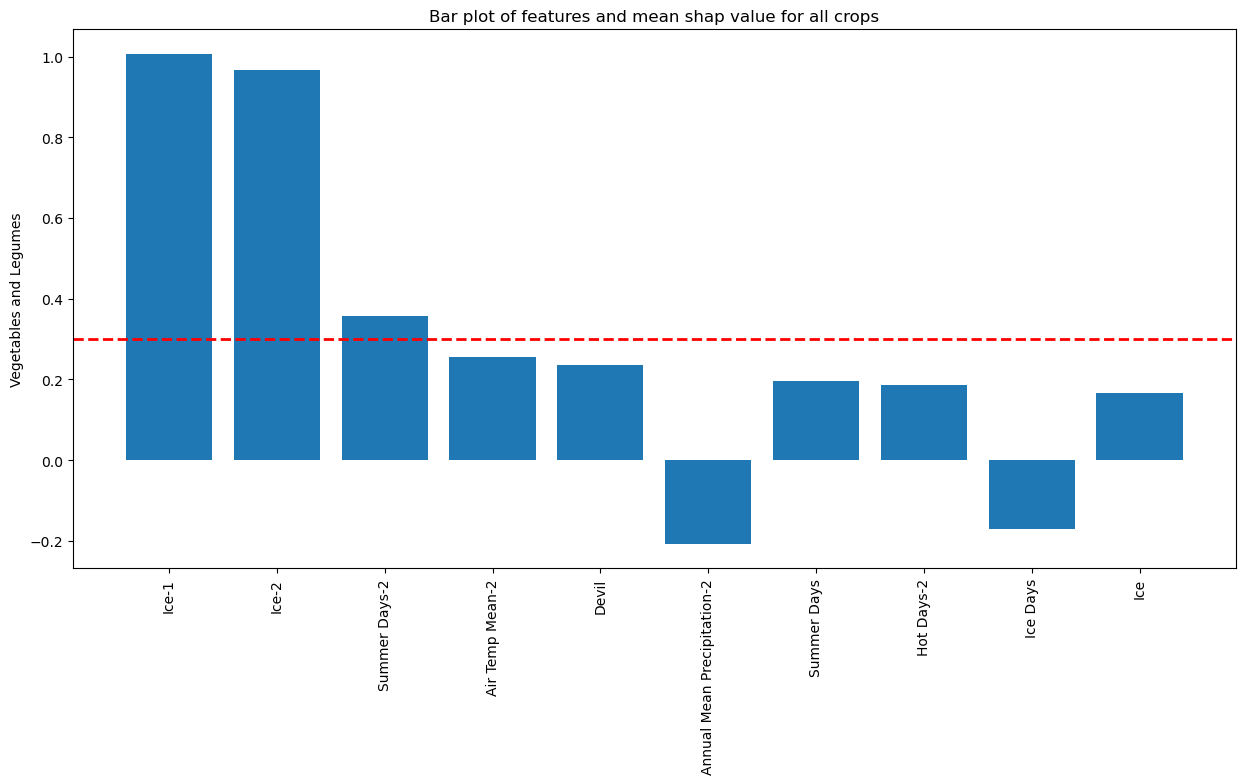

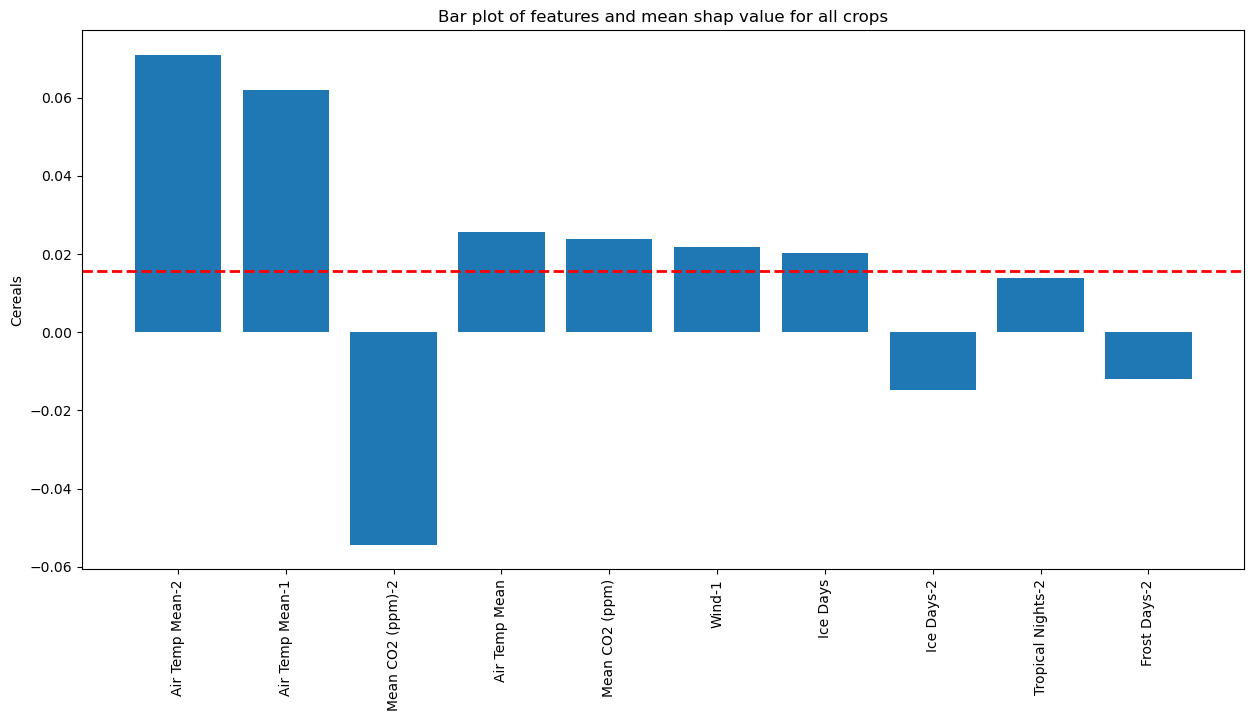

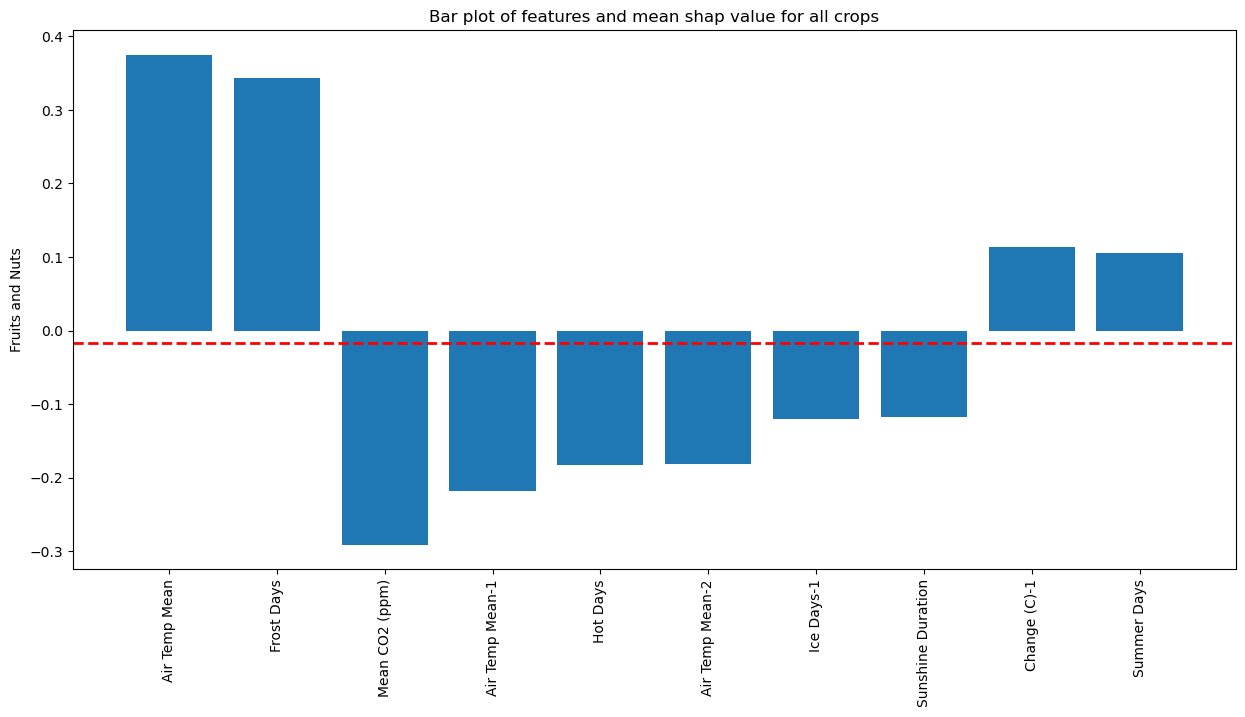

In [9]:
shap_rows = shap_df.index
shap_rows = shap_rows.drop(['Yield (tonnes/ha)-1', 'Yield (tonnes/ha)-2', 'Fall', 'Spring', 'Summer', 'Year-Round'])

for cat in categories:
    crop_df = pd.DataFrame(shap_df.loc[shap_rows][cat], columns=[cat])
    sorted_df = crop_df.reindex(crop_df[cat].abs().sort_values(ascending=False).index)

    top_10 = sorted_df.head(10)

    #sorted_means = sorted(mean_shap, key=abs, reverse=True)
    #top_values = sorted_means[:10]
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.bar(top_10.index, top_10[cat])
    ax.axhline(top_10[cat].mean(), color='red', linestyle='dashed', linewidth=2)
    ax.set_xticklabels(top_10.index, rotation=90)
    ax.set_ylabel(cat)
    ax.set_title('Bar plot of features and mean shap value for all crops')

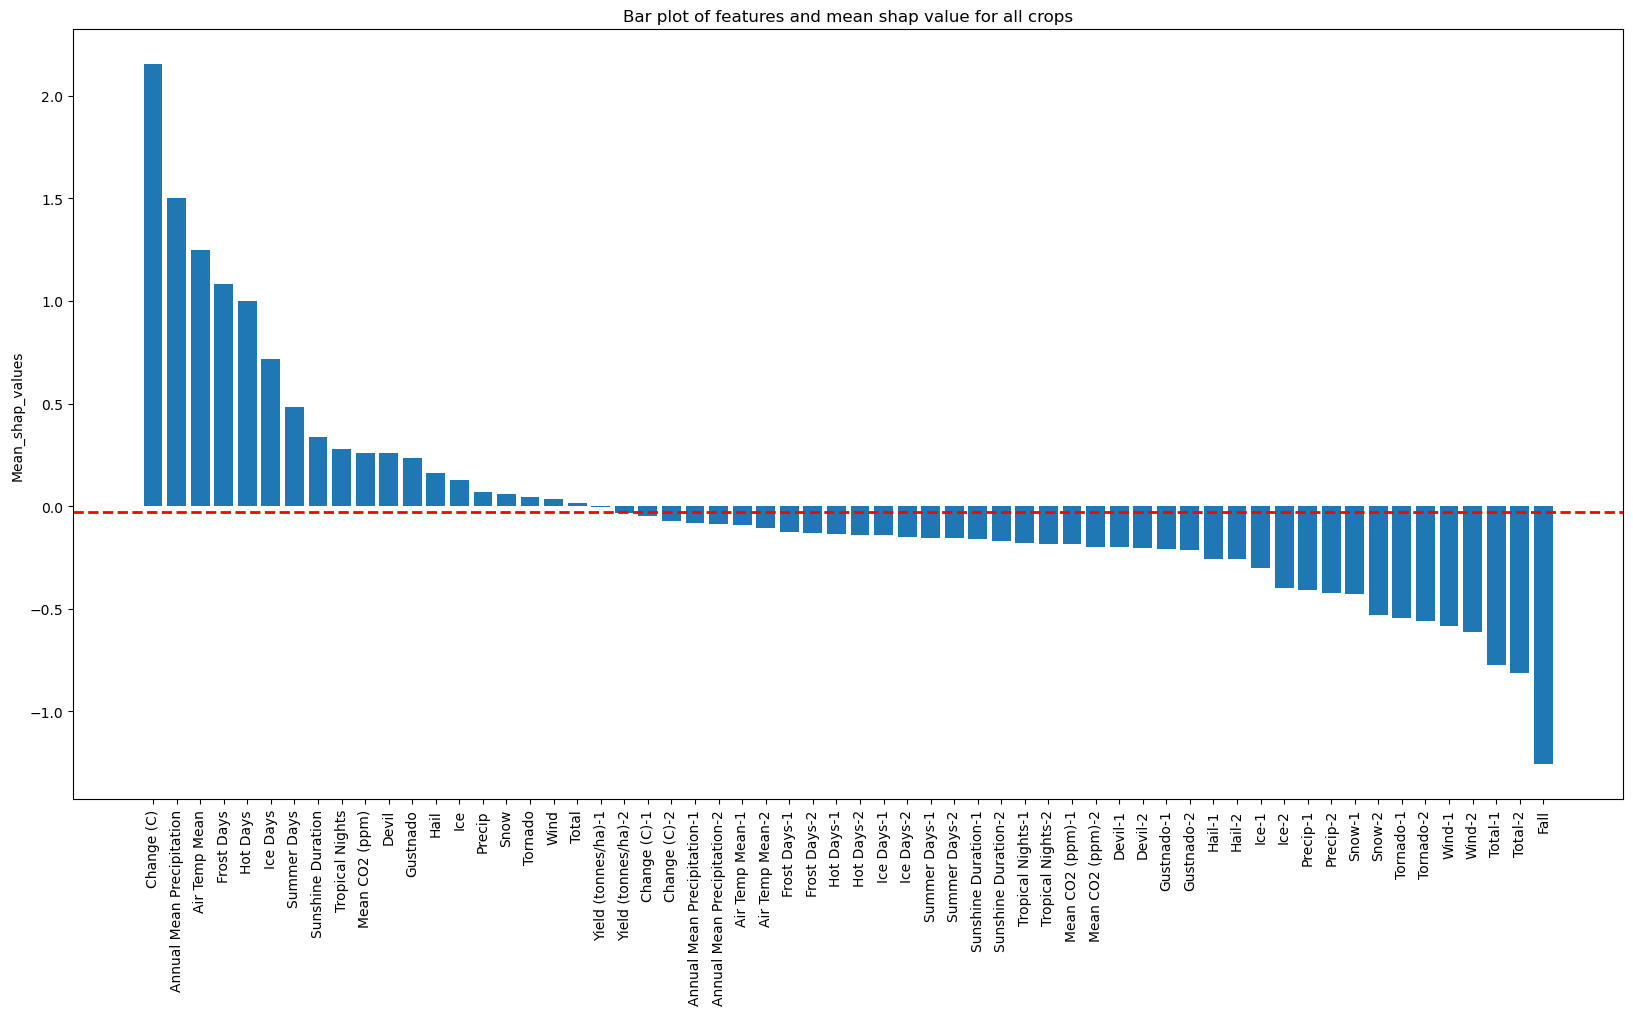

In [10]:
scaler = StandardScaler()
scaler.fit(shap_df)
shap_gen = pd.DataFrame(scaler.transform(shap_df), columns=shap_df.columns, index=shap_df.index)
shap_gen['mean_shap_value'] = shap_gen.mean(axis=1)
shap_gen = shap_gen.sort_values(by='mean_shap_value', ascending=False)
shap_gen = shap_gen.dropna()
mean_shap = shap_gen['mean_shap_value'].mean()
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(shap_gen.index, shap_gen['mean_shap_value'])
ax.axhline(mean_shap, color='red', linestyle='dashed', linewidth=2)
ax.set_xticklabels(x, rotation=90)
ax.set_ylabel('Mean_shap_values')
ax.set_title('Bar plot of features and mean shap value for all crops')
plt.show()